<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU (CUDA) Otomatik Algılama
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")


Kullanılan Cihaz: cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0723.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0724.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0725.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [4]:
# 2. Veri Yolları ve Hiperparametreler
DATA_DIR = '/content/Dataset_224x224'
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10

In [5]:
# 3. MRI Görüntüleri İçin Data Augmentation ve Normalizasyon
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [6]:
# 4. EfficientNetB0 Model Yapılandırması
def get_densenet121_model():
    model = models.densenet121(
        weights=models.DenseNet121_Weights.IMAGENET1K_V1
    )

    features = model.features

    # %40 civarı katman dondurma (DenseNet mantığı)
    freeze_layers = [
        features.conv0,
        features.norm0,
        features.relu0,
        features.pool0,
        features.denseblock1,
        features.transition1
    ]

    for layer in freeze_layers:
        for param in layer.parameters():
            param.requires_grad = False

    # Üst katmanlar trainable
    for layer in [
        features.denseblock2,
        features.transition2,
        features.denseblock3,
        features.transition3,
        features.denseblock4
    ]:
        for param in layer.parameters():
            param.requires_grad = True

    # Classifier uyarlama
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)

    return model.to(device)


In [7]:
# 5. Dataset Sınıfı
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [8]:
# 6. 5-Fold Stratified Cross-Validation ve Eğitim
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} / 5 ---")

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    # Dinamik transform atama
    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_densenet121_model()

    # Differential Learning Rate Tanımlama
    optimizer = optim.Adam([
    {'params': model.features.denseblock2.parameters(), 'lr': 1e-5},
    {'params': model.features.transition2.parameters(), 'lr': 1e-5},

    {'params': model.features.denseblock3.parameters(), 'lr': 5e-5},
    {'params': model.features.transition3.parameters(), 'lr': 5e-5},

    {'params': model.features.denseblock4.parameters(), 'lr': 1e-4},

    {'params': model.classifier.parameters(), 'lr': 1e-3}
])


    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_PER_FOLD):
        # Training Phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels_batch in train_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels_batch.data)

        train_epoch_loss = running_loss / len(train_idx)
        train_epoch_acc = running_corrects.double() / len(train_idx)

        # Validation Phase
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels_batch in val_loader:
                inputs, labels_batch = inputs.to(device), labels_batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_batch)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels_batch.data)

        val_epoch_loss = val_running_loss / len(val_idx)
        val_epoch_acc = val_running_corrects.double() / len(val_idx)

        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc.cpu().item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.cpu().item())

        print(f"Epoch {epoch+1}/{EPOCHS_PER_FOLD} - Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    fold_histories.append(history)


--- FOLD 1 / 5 ---
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 183MB/s]


Epoch 1/10 - Train Loss: 0.2860 Acc: 0.9004 | Val Loss: 0.0965 Acc: 0.9676
Epoch 2/10 - Train Loss: 0.0513 Acc: 0.9853 | Val Loss: 0.1022 Acc: 0.9615
Epoch 3/10 - Train Loss: 0.0209 Acc: 0.9939 | Val Loss: 0.0553 Acc: 0.9790
Epoch 4/10 - Train Loss: 0.0091 Acc: 0.9980 | Val Loss: 0.0563 Acc: 0.9790
Epoch 5/10 - Train Loss: 0.0085 Acc: 0.9974 | Val Loss: 0.0586 Acc: 0.9746
Epoch 6/10 - Train Loss: 0.0086 Acc: 0.9985 | Val Loss: 0.0881 Acc: 0.9764
Epoch 7/10 - Train Loss: 0.0063 Acc: 0.9982 | Val Loss: 0.0569 Acc: 0.9869
Epoch 8/10 - Train Loss: 0.0039 Acc: 0.9993 | Val Loss: 0.0774 Acc: 0.9825
Epoch 9/10 - Train Loss: 0.0080 Acc: 0.9976 | Val Loss: 0.0771 Acc: 0.9764
Epoch 10/10 - Train Loss: 0.0146 Acc: 0.9956 | Val Loss: 0.0602 Acc: 0.9799

--- FOLD 2 / 5 ---
Epoch 1/10 - Train Loss: 0.2986 Acc: 0.8943 | Val Loss: 0.0863 Acc: 0.9746
Epoch 2/10 - Train Loss: 0.0580 Acc: 0.9812 | Val Loss: 0.0907 Acc: 0.9720
Epoch 3/10 - Train Loss: 0.0207 Acc: 0.9950 | Val Loss: 0.0484 Acc: 0.9869
Epoc

In [9]:
# 7. Final Test Değerlendirmesi
print("\n--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels_batch in test_loader:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metriklerin Hesaplanması
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"\nSayısal Test Sonuçları:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---

Sayısal Test Sonuçları:
Accuracy:  0.9855
Precision: 0.9855
Recall:    0.9855
F1-Score:  0.9855
ROC-AUC:   0.9994


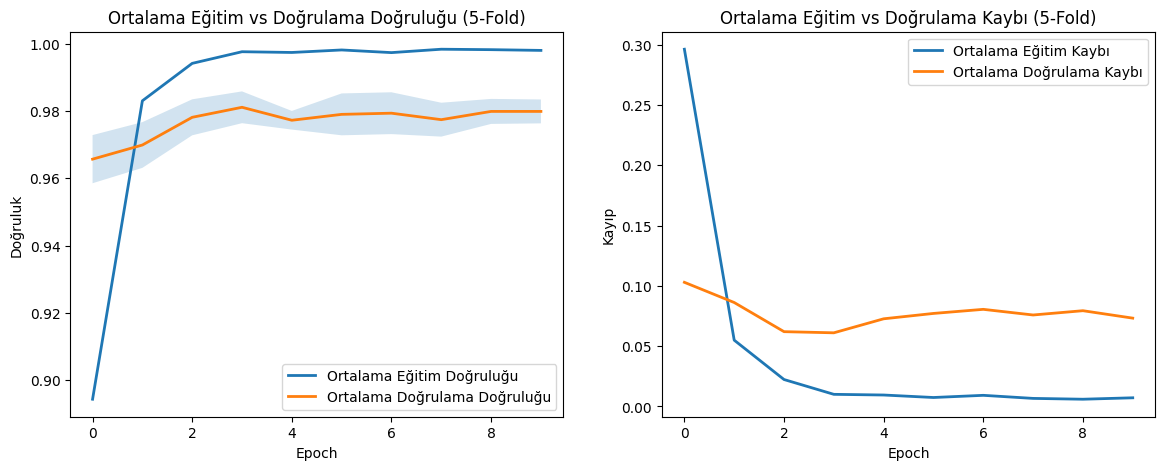

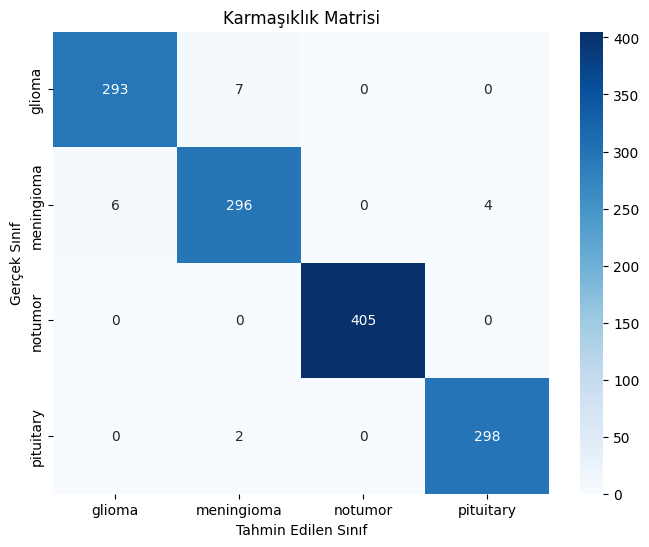

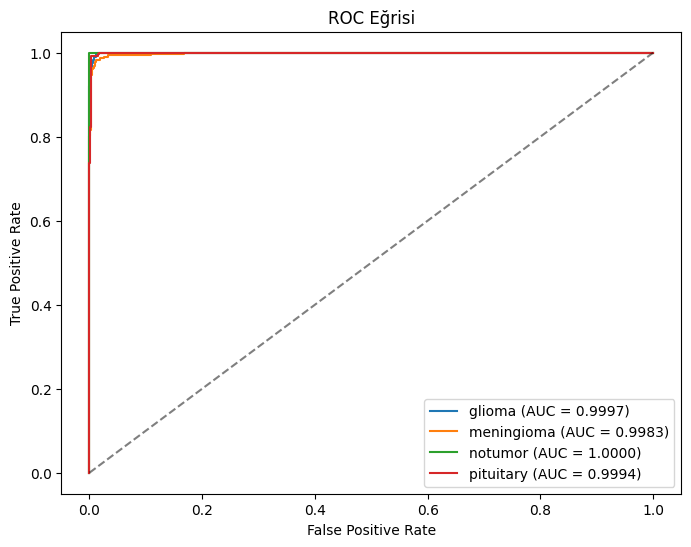

In [10]:
# 8. GRAFİKLER

# --- A. Ortalama Accuracy ve Loss Grafikleri (5-Fold Mean) ---
epochs = range(len(fold_histories[0]['train_acc']))
train_accs = np.array([h['train_acc'] for h in fold_histories])
val_accs = np.array([h['val_acc'] for h in fold_histories])
train_losses = np.array([h['train_loss'] for h in fold_histories])
val_losses = np.array([h['val_loss'] for h in fold_histories])

plt.figure(figsize=(14, 5))

# Ortalama Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_accs, axis=0), label='Ortalama Eğitim Doğruluğu', lw=2)
plt.plot(epochs, np.mean(val_accs, axis=0), label='Ortalama Doğrulama Doğruluğu', lw=2)
# Standart Sapma Gölgelendirmesi (Opsiyonel ama çok profesyonel durur)
plt.fill_between(epochs, np.mean(val_accs, axis=0) - np.std(val_accs, axis=0),
                 np.mean(val_accs, axis=0) + np.std(val_accs, axis=0), alpha=0.2)
plt.title('Ortalama Eğitim vs Doğrulama Doğruluğu (5-Fold)')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Ortalama Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_losses, axis=0), label='Ortalama Eğitim Kaybı', lw=2)
plt.plot(epochs, np.mean(val_losses, axis=0), label='Ortalama Doğrulama Kaybı', lw=2)
plt.title('Ortalama Eğitim vs Doğrulama Kaybı (5-Fold)')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# --- B. Confusion Matrix  ---

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# --- C. ROC Eğrisi  ---
plt.figure(figsize=(8, 6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
    current_auc = roc_auc_score(np.array(all_labels) == i, np.array(all_probs)[:, i])
    plt.plot(fpr, tpr, label=f'{test_dataset.classes[i]} (AUC = {current_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()